In [23]:
import numpy as np
import pandas as pd

import numpyro
import numpyro.distributions as dist

import jax
import arviz as az

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

In [3]:
size = 30
a = 2
b = 1

x_clean = np.linspace(0, 1, size)
y_clean = a * x_clean + b

y_noised = y_clean + np.random.normal(scale=0.5, size=len(y_clean))

x_obs = np.append(x_clean, [0.1, 0.15, 0.2])
y_obs = np.append(y_noised, [8, 6, 9])

data_clean = pd.DataFrame(dict(x=x_clean, y=y_clean))
data_observed = pd.DataFrame(dict(x=x_obs, y=y_obs))

In [4]:
numpyro.set_platform("cpu")

In [7]:
x_clean = data_clean["x"].values
y_clean = data_clean["y"].values

x_observed = data_observed["x"].values
y_observed = data_observed["y"].values

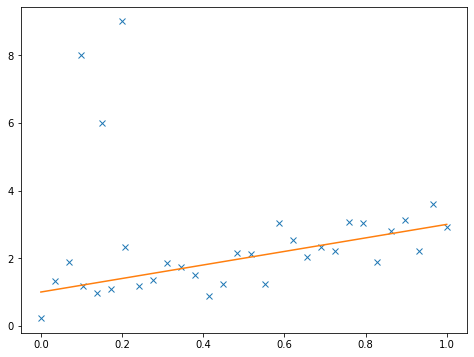

In [8]:
fig = plt.figure(figsize=(8, 6))
plt.plot(x_observed, y_observed, "x")
plt.plot(x_clean, y_clean)

## ベイズ線型回帰

In [26]:
def model(x, y):
    #回帰の重みパラメタの事前分布
    a = numpyro.sample("a", dist.Normal(0, 10))
    b = numpyro.sample("b", dist.Normal(0, 10))
    
    #回帰式
    mu = a * x + b
    
    # 尤度の分散パラの事前分布
    sc = numpyro.sample("sc", dist.HalfNormal(10))
    
    # 尤度
    obs = numpyro.sample("obs", dist.Normal(mu, sc), obs=y)

In [10]:
nuts = numpyro.infer.NUTS(model) #モデルを定義した関数を渡す
mcmc = numpyro.infer.MCMC(nuts, num_warmup=500, num_samples=3000, num_chains=4)

mcmc.run(jax.random.PRNGKey(0), x_observed, y_observed)
trace = mcmc.get_samples()
idata = az.from_numpyro(mcmc)

/tmp/ipykernel_21733/3392366470.py:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(nuts, num_warmup=500, num_samples=3000, num_chains=4)
sample: 100%|█| 3500/3500 [00:06<00:00, 515.31it/s, 7 steps of size 4.12e-01. ac
sample: 100%|█| 3500/3500 [00:02<00:00, 1363.46it/s, 7 steps of size 4.75e-01. a
sample: 100%|█| 3500/3500 [00:02<00:00, 1441.88it/s, 15 steps of size 4.62e-01. 
sample: 100%|█| 3500/3500 [00:02<00:00, 1494.60it/s, 7 steps of size 3.85e-01. a


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'sc'}>,
        <AxesSubplot:title={'center':'sc'}>]], dtype=object)

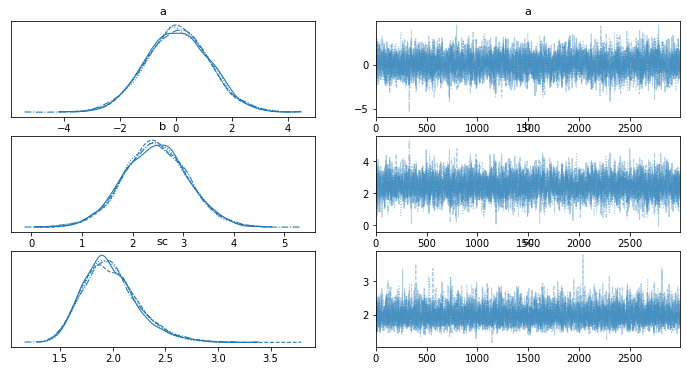

In [11]:
az.plot_trace(idata)

In [12]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.062,1.138,-2.147,2.141,0.017,0.012,4688.0,5335.0,1.0
b,2.457,0.636,1.207,3.608,0.009,0.007,4655.0,5421.0,1.0
sc,1.982,0.267,1.524,2.498,0.003,0.002,6047.0,6445.0,1.0


## ロバストベイズ線型回帰

In [15]:
def robust_model(x,y):
    a = numpyro.sample("a", dist.Normal(0, 10))
    b = numpyro.sample("b", dist.Normal(0, 10))
    
    mu = a * x + b
    
    nu = numpyro.sample("nu", dist.Gamma(2.0, 0.1))
    sc = numpyro.sample("sc", dist.HalfNormal(10))
    
    obs = numpyro.sample("obs", dist.StudentT(nu, loc=mu, scale=sc), obs=y)

In [16]:
nuts = numpyro.infer.NUTS(robust_model)
mcmc = numpyro.infer.MCMC(nuts, num_warmup=500, num_samples=3000, num_chains = 4)

mcmc.run(jax.random.PRNGKey(0), x_observed, y_observed)
trace_robust = mcmc.get_samples()
idata_robust = az.from_numpyro(mcmc)

/tmp/ipykernel_21733/3565796446.py:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(nuts, num_warmup=500, num_samples=3000, num_chains = 4)
sample: 100%|█| 3500/3500 [00:07<00:00, 459.92it/s, 15 steps of size 3.36e-01. a
sample: 100%|█| 3500/3500 [00:03<00:00, 1158.22it/s, 7 steps of size 2.97e-01. a
sample: 100%|█| 3500/3500 [00:02<00:00, 1324.02it/s, 15 steps of size 3.66e-01. 
sample: 100%|█| 3500/3500 [00:02<00:00, 1346.76it/s, 7 steps of size 2.64e-01. a


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'nu'}>,
        <AxesSubplot:title={'center':'nu'}>],
       [<AxesSubplot:title={'center':'sc'}>,
        <AxesSubplot:title={'center':'sc'}>]], dtype=object)

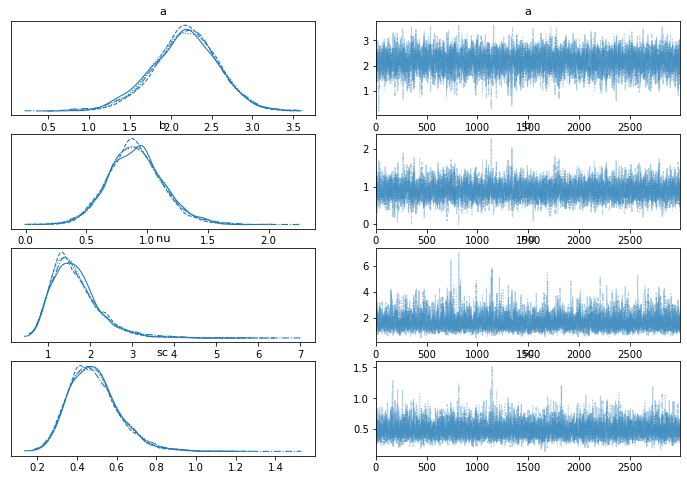

In [17]:
az.plot_trace(idata_robust)

In [20]:
az.summary(idata_robust)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,2.178,0.403,1.395,2.922,0.006,0.004,4424.0,4894.0,1.0
b,0.903,0.227,0.486,1.345,0.003,0.003,4439.0,4744.0,1.0
nu,1.653,0.590,0.733,2.744,0.008,0.006,5731.0,6526.0,1.0
sc,0.486,0.129,0.262,0.725,0.002,0.001,6109.0,6502.0,1.0


In [22]:
def plot_lines(trace, ax, samples_to_plot=50):
    x = np.linspace(0, 1)
    for k in range(1, samples_to_plot):
        
        a_sample = trace["a"][-k]
        b_sample = trace["b"][-k]
        
        mu = a_sample * x + b_sample
        
        ax.plot(x, mu, c="g", alpha=0.1)

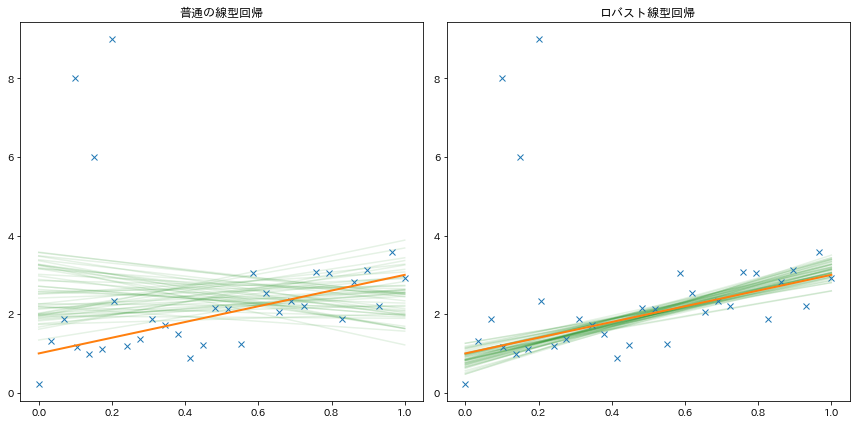

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plot_lines(trace, axes[0])
axes[0].plot(x_observed, y_observed, "x")
axes[0].plot(x_clean, y_clean, lw=2)
axes[0].set_title("普通の線型回帰")

plot_lines(trace_robust, axes[1])
axes[1].plot(x_observed, y_observed, "x")
axes[1].plot(x_clean, y_clean, lw=2)
axes[1].set_title("ロバスト線型回帰")
plt.tight_layout()

In [31]:
az.waic(idata, scale="deviance")

/home/inoma/.local/share/virtualenvs/Py_bayes-Xd0WuMm8/lib/python3.8/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 12000 posterior samples and 33 observations log-likelihood matrix.

              Estimate       SE
deviance_waic   143.31    16.93
p_waic            5.08        -

There has been a warning during the calculation. Please check the results.

In [29]:
az.waic(idata_robust, scale="deviance")

/home/inoma/.local/share/virtualenvs/Py_bayes-Xd0WuMm8/lib/python3.8/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 12000 posterior samples and 33 observations log-likelihood matrix.

              Estimate       SE
deviance_waic   100.61    19.97
p_waic            4.37        -

There has been a warning during the calculation. Please check the results.

In [32]:
dict_idata = {"Normal":idata, "Robust":idata_robust}
df_waic = az.compare(dict_idata, ic="waic", scale="deviance")
df_waic

/home/inoma/.local/share/virtualenvs/Py_bayes-Xd0WuMm8/lib/python3.8/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/inoma/.local/share/virtualenvs/Py_bayes-Xd0WuMm8/lib/python3.8/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Robust,0,100.614864,4.365439,0.000000,1.000000e+00,19.973170,0.000000,True,deviance
Normal,1,143.313279,5.080337,42.698415,9.556800e-13,16.926855,9.094365,True,deviance


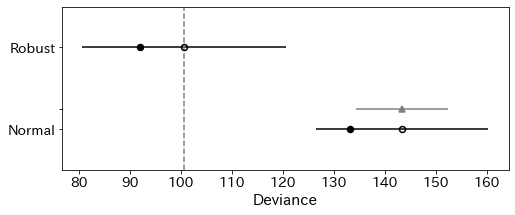

In [33]:
az.plot_compare(df_waic, figsize=(8, 3));